# 03 Train Transformer Model
Dieses Notebook trainiert den TimeSeriesTransformer.

In [1]:
import os, sys, json, pickle, random, shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from pathlib import Path
from sklearn.preprocessing import StandardScaler

# Add root project to path
ROOT = Path("..").resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from finance_transformer.dataset import WindowDataset
from finance_transformer.model import TimeSeriesTransformer
from finance_transformer.metrics import directional_accuracy

%matplotlib inline

In [2]:
# === KONFIGURATION ===
CFG = dict(
    ticker="AAPL",
    start="2010-01-01",
    end="2025-01-01",
    seq_len=40,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_ff=128,
    dropout=0.3,
    lr=1e-4,
    weight_decay=0.05,
    batch_size=64,
    epochs=100,
    patience=15,
    train_end="2023-12-31",
    valid_end="2024-12-31",
    seed=42,
    results_dir="../results"
)

RESULTS_DIR = ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Set seeds
random.seed(CFG["seed"])
np.random.seed(CFG["seed"])
torch.manual_seed(CFG["seed"])
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [3]:
# === DATEN LADEN ===
DATA_PATH = Path(r"../../LSTM/data/AAPL_1d_2010-01-01_2026-01-01_cls_h1_abs0p0005.csv").resolve()
if not DATA_PATH.exists():
    print(f"Resolving path: {DATA_PATH}")
    raise FileNotFoundError(f"{DATA_PATH} not found. Please ensure LSTM data is generated.")

df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
print(f"Loaded {len(df)} rows.")


# Filter by start date defined in config
df = df.loc[CFG["start"]:]
print(f"Filtered data start: {df.index[0]}")

feat_cols = ['logret_1d', 'logret_3d', 'logret_5d', 'realized_vol_10', 'bb_pos', 'rsi_14', 'macd', 'macd_sig', 'macd_diff', 'vol_z_20', 'sma_diff']

# Target: Use existing "target" column for classification (0/1)
if "target" not in df.columns:
    raise ValueError("Target column not found in dataset!")
df["y"] = df["target"]
print(f"Features used: {len(feat_cols)}")

Loaded 3991 rows.
Filtered data start: 2010-02-22 00:00:00
Features used: 11


In [4]:
# === SPLIT & SCALING ===
tr_df = df.loc[:CFG["train_end"]]
va_df = df.loc[pd.Timestamp(CFG["train_end"]) + pd.Timedelta(days=1):CFG["valid_end"]]
# Test Split ab Valid End bis Ende (für spätere Evaluation)
te_df = df.loc[pd.Timestamp(CFG["valid_end"]) + pd.Timedelta(days=1):]

print(f"Train: {len(tr_df)}, Val: {len(va_df)}, Test: {len(te_df)}")

scaler = StandardScaler().fit(tr_df[feat_cols])

X_tr = scaler.transform(tr_df[feat_cols]).astype("float32")
y_tr = tr_df["y"].values.astype("float32")

X_va = scaler.transform(va_df[feat_cols]).astype("float32")
y_va = va_df["y"].values.astype("float32")

# Datasets & Loaders
ds_tr = WindowDataset(X_tr, y_tr, CFG["seq_len"])
ds_va = WindowDataset(X_va, y_va, CFG["seq_len"])

dl_tr = DataLoader(ds_tr, batch_size=CFG["batch_size"], shuffle=True)
dl_va = DataLoader(ds_va, batch_size=CFG["batch_size"], shuffle=False)

Train: 3489, Val: 252, Test: 250


In [5]:
# === MODEL INITIALISIERUNG ===
model = TimeSeriesTransformer(
    in_features=len(feat_cols), 
    d_model=CFG["d_model"], 
    nhead=CFG["nhead"], 
    num_layers=CFG["num_layers"], 
    dim_ff=CFG["dim_ff"], 
    dropout=CFG["dropout"]
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

c:\Users\jacin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [6]:
# === TRAINING LOOP ===
best_loss = float("inf")
wait = 0
history = []

for ep in range(CFG["epochs"]):
    model.train()
    tr_loss = 0
    for xb, yb in dl_tr:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item() * xb.size(0)
    tr_loss /= len(dl_tr.dataset)

    model.eval()
    va_loss, preds, gts = 0, [], []
    with torch.no_grad():
        for xb, yb in dl_va:
            xb, yb = xb.to(device), yb.to(device)
            p = model(xb)
            va_loss += loss_fn(p, yb).item() * xb.size(0)
            preds.append(p.cpu().numpy())
            gts.append(yb.cpu().numpy())
    
    va_loss /= len(dl_va.dataset)
    scheduler.step(va_loss)
    
    # Binary Accuracy Calculation
    all_preds = np.concatenate(preds).flatten()
    all_gts = np.concatenate(gts).flatten()
    # Logits > 0 implies Prob > 0.5 implies Class 1
    pred_classes = (all_preds > 0).astype(int)
    da = (pred_classes == all_gts).mean()
    
    history.append({"epoch": ep, "train_loss": tr_loss, "val_loss": va_loss, "val_acc": da})
    print(f"Epoch {ep+1:02d} | Train Loss: {tr_loss:.6f} | Val Loss: {va_loss:.6f} | Acc: {da:.3f}")

    if va_loss < best_loss:
        best_loss = va_loss
        wait = 0
        # Save Model
        torch.save(model.state_dict(), RESULTS_DIR / "model.pt")
    else:
        wait += 1
        if wait >= CFG["patience"]:
            print(f"Early stopping at epoch {ep+1}")
            break

Epoch 01 | Train Loss: 0.696933 | Val Loss: 0.700127 | Acc: 0.448
Epoch 02 | Train Loss: 0.692774 | Val Loss: 0.702058 | Acc: 0.476
Epoch 03 | Train Loss: 0.693635 | Val Loss: 0.702694 | Acc: 0.462
Epoch 04 | Train Loss: 0.690936 | Val Loss: 0.700456 | Acc: 0.472
Epoch 05 | Train Loss: 0.692715 | Val Loss: 0.702595 | Acc: 0.458
Epoch 06 | Train Loss: 0.691832 | Val Loss: 0.702806 | Acc: 0.453
Epoch 07 | Train Loss: 0.693411 | Val Loss: 0.703202 | Acc: 0.462
Epoch 08 | Train Loss: 0.691302 | Val Loss: 0.703567 | Acc: 0.467
Epoch 09 | Train Loss: 0.693144 | Val Loss: 0.703549 | Acc: 0.467
Epoch 10 | Train Loss: 0.691922 | Val Loss: 0.704820 | Acc: 0.462
Epoch 11 | Train Loss: 0.691388 | Val Loss: 0.704030 | Acc: 0.458
Epoch 12 | Train Loss: 0.690768 | Val Loss: 0.704676 | Acc: 0.453
Epoch 13 | Train Loss: 0.690184 | Val Loss: 0.704788 | Acc: 0.462
Epoch 14 | Train Loss: 0.689317 | Val Loss: 0.704857 | Acc: 0.458
Epoch 15 | Train Loss: 0.691143 | Val Loss: 0.705103 | Acc: 0.462
Epoch 16 |

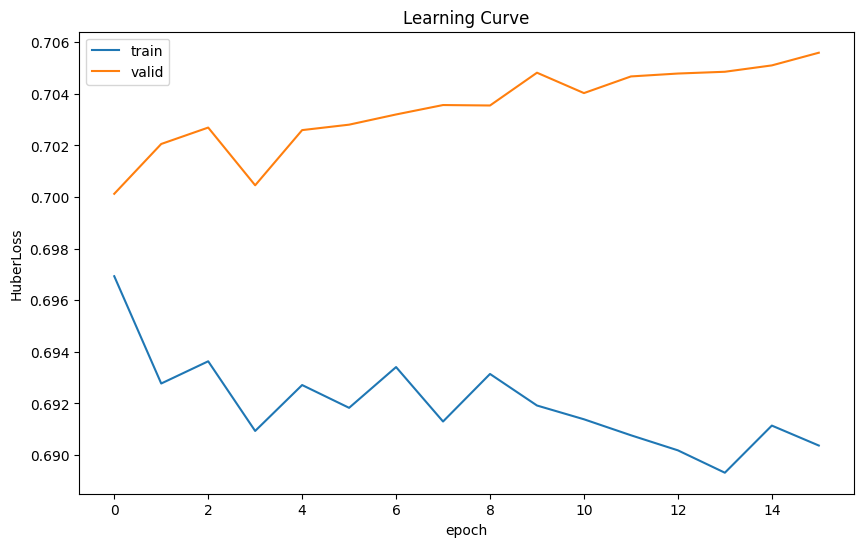

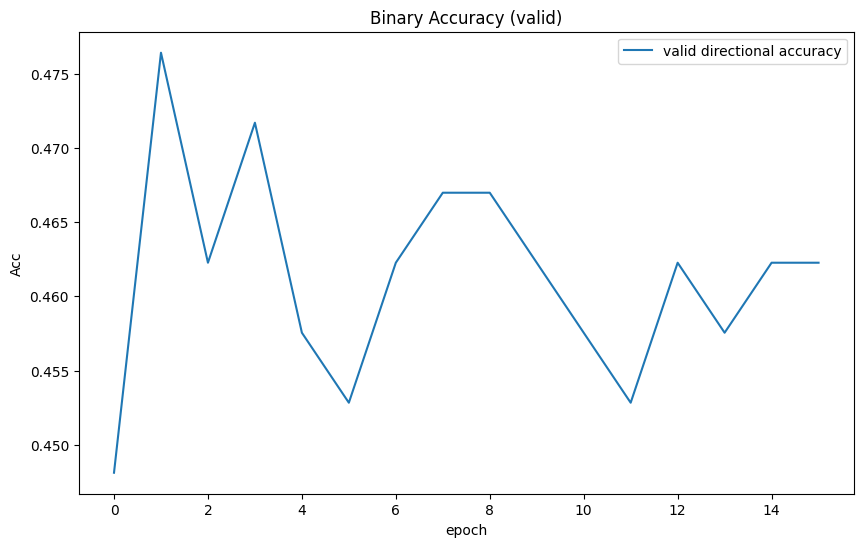

Training finished. Artifacts saved to C:\Users\jacin\DL_PROJECT\finance_transformer_lstm\TRANSFORMER\results


In [7]:
# === ARTEFAKTE SPEICHERN ===
pd.DataFrame(history).to_csv(RESULTS_DIR / "history.csv", index=False)

with open(RESULTS_DIR / "config.json", "w") as f:
    json.dump({"cfg": CFG, "feat_cols": feat_cols}, f, indent=2)

with open(RESULTS_DIR / "scaler.pkl", "wb") as f:
    pickle.dump({"scaler": scaler, "feat_cols": feat_cols}, f)
    
# === PLOTTING ===
hist_df = pd.DataFrame(history)

# 1. Learning Curve (Loss)
plt.figure(figsize=(10, 6))
plt.plot(hist_df["epoch"], hist_df["train_loss"], label="train")
plt.plot(hist_df["epoch"], hist_df["val_loss"], label="valid")
plt.title("Learning Curve")
plt.xlabel("epoch")
plt.ylabel("HuberLoss")
plt.legend()
plt.savefig(RESULTS_DIR / "loss.png")
plt.show()

# 2. Binary Accuracy
plt.figure(figsize=(10, 6))
plt.plot(hist_df["epoch"], hist_df["val_acc"], label="valid directional accuracy")
plt.title("Binary Accuracy (valid)")
plt.xlabel("epoch")
plt.ylabel("Acc")
plt.legend()
plt.savefig(RESULTS_DIR / "valid_diracc.png")
plt.show()

print(f"Training finished. Artifacts saved to {RESULTS_DIR}")